In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv')

In [3]:
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
DATE         573 non-null object
IPN31152N    573 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


In [7]:
df.isnull().sum()

DATE         0
IPN31152N    0
dtype: int64

In [9]:
df = pd.read_csv('Frozen_Dessert_Production.csv', index_col = "DATE", parse_dates = True)

In [10]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
IPN31152N    573 non-null float64
dtypes: float64(1)
memory usage: 9.0 KB


In [12]:
df.columns = ['Production']

In [13]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


<AxesSubplot:xlabel='DATE'>

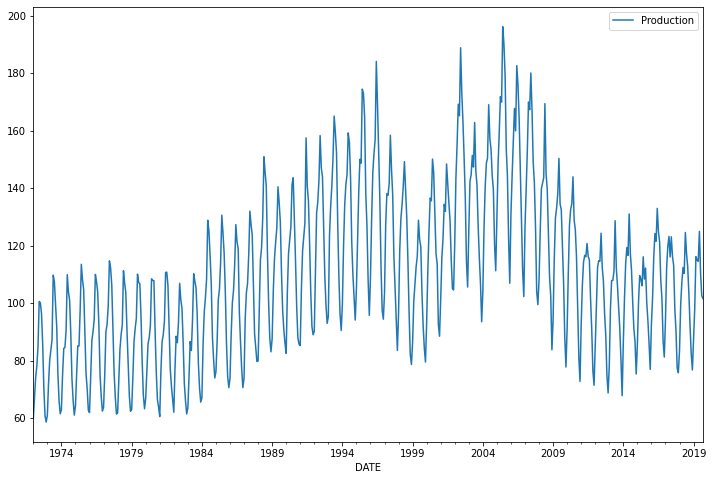

In [16]:
df.plot(figsize = (12,8))

In [17]:
len(df)

573

In [19]:
test_size = 24
test_index = len(df) - test_size

In [21]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [23]:
len(test)

24

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 18
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size = 1)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [32]:
model = Sequential()
model.add(LSTM(100, input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size=1)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [37]:
model.fit(generator, epochs = 20, validation_data=validation_generator, callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 531 steps, validate for 6 steps
Epoch 1/20
531/531 [==============================] - 12s 23ms/step - loss: 0.0189 - val_loss: 0.0021
Epoch 2/20
531/531 [==============================] - 8s 14ms/step - loss: 0.0048 - val_loss: 0.0105
Epoch 3/20
531/531 [==============================] - 8s 14ms/step - loss: 0.0037 - val_loss: 0.0020- ETA: 0s - loss: 0. - ETA: 0s - loss: 0.
Epoch 4/20
531/531 [==============================] - 8s 16ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 5/20
531/531 [==============================] - 8s 15ms/step - loss: 0.0035 - val_loss: 0.0061
Epoch 6/20
531/531 [==============================] - 8s 15ms/step - loss: 0.0036 - val_loss: 0.0066


<AxesSubplot:>

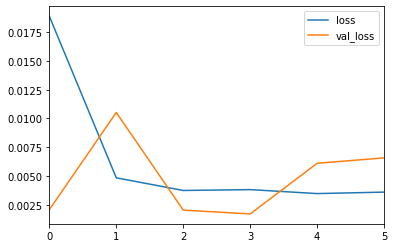

In [38]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [42]:
test_predictions = []

first_eval_batch =  scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range (len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1) 

In [44]:
true_predictions = scaler.inverse_transform(test_predictions)

In [45]:
test['Predictions'] = true_predictions

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
test.head()

,Production,Predictions
DATE,,
2017-10-01,90.4732,99.398516
2017-11-01,77.4378,98.180472
2017-12-01,75.8118,101.197682
2018-01-01,83.4343,108.654246
2018-02-01,99.4899,117.872882


<AxesSubplot:xlabel='DATE'>

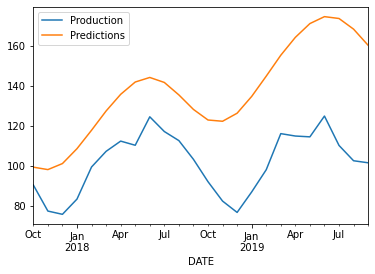

In [47]:
test.plot()

In [48]:
from sklearn.metrics import mean_squared_error

In [51]:
mean_squared_error(test['Production'], test['Predictions'])

1549.1872752241736

In [52]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

39.35971640172441

In [53]:
# improving model performene by decreasing the betch size from 24 months to 18 months
test_size = 18
test_index = len(df) - test_size

train = df.iloc[:test_index]
test = df.iloc[test_index:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

length = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size = 1)

In [54]:
model = Sequential()
model.add(LSTM(150, input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [55]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size=1)
model.fit(generator, epochs = 20, validation_data=validation_generator, callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 543 steps, validate for 6 steps
Epoch 1/20
543/543 [==============================] - 9s 16ms/step - loss: 0.0179 - val_loss: 0.0016
Epoch 2/20
543/543 [==============================] - 6s 11ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 3/20
543/543 [==============================] - 6s 11ms/step - loss: 0.0038 - val_loss: 0.0021


<AxesSubplot:>

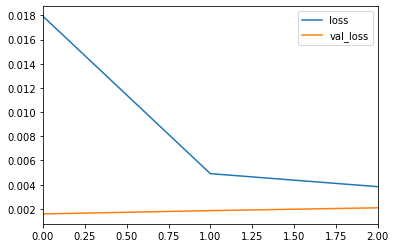

In [56]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [57]:
test_predictions = []

first_eval_batch =  scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range (len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1) 

In [58]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.head()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Production,Predictions
DATE,,
2018-04-01,112.4309,116.890486
2018-05-01,110.3544,122.146229
2018-06-01,124.5841,124.169638
2018-07-01,117.2215,120.425385
2018-08-01,112.6779,112.086328


<AxesSubplot:xlabel='DATE'>

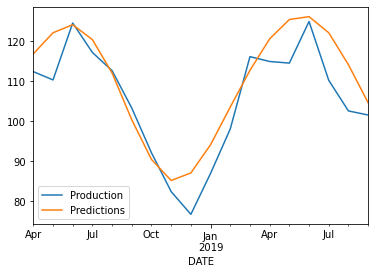

In [59]:
test.plot()

In [60]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

6.770631553260613